In [1]:
!pip install np_utils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install spectral

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install keras
!pip install tensorflow
!pip install scikit-learn
!pip install plotly
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
#os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# !rm -r sample_data


2024-04-22 12:12:49.822821: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 12:12:49.953958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 12:12:50.612521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# if not (os.path.isfile('Indian_pines_corrected.mat')):
#   !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
# if not (os.path.isfile('Indian_pines_gt.mat')):
#   !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

# Data Loading

In [6]:
## GLOBAL VARIABLES
dataset = 'SNPA'
test_ratio = 0.7
windowSize = 25

In [9]:
def loadData(name):
    data_path = '../matrices A extracted with SNPA/'

    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'SNPA':
        data = sio.loadmat(os.path.join(data_path, 'result_snpa_pavia.mat'))['Apu']
        

    return data
data=loadData(dataset)
data.shape

(103, 9)

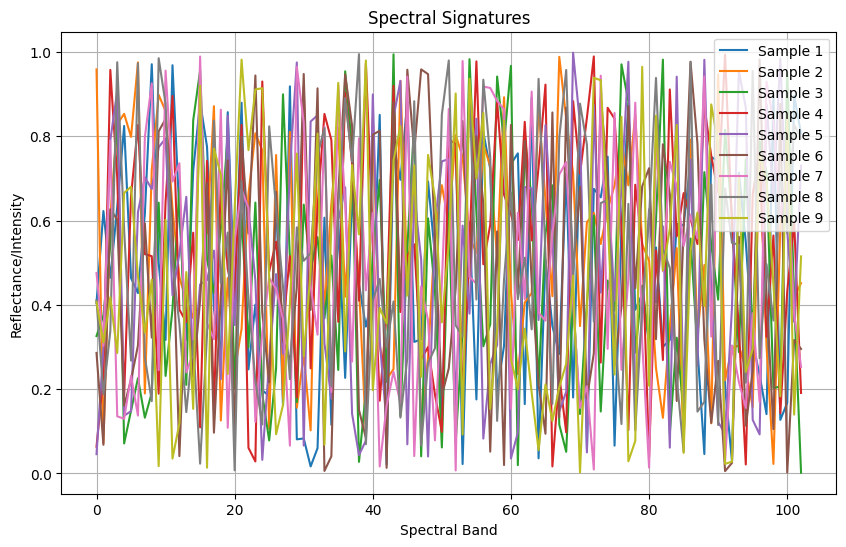

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming A_matrixPU_information is your data matrix
data = np.random.rand(103, 9)  # Example random data, replace it with your actual data

# Transposing the matrix to plot spectral signatures
A_transposed = data.T

# Plotting spectral signatures
plt.figure(figsize=(10, 6))
for i in range(len(A_transposed)):
    plt.plot(A_transposed[i], label=f'Sample {i+1}')

plt.title('Spectral Signatures')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance/Intensity')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

((610, 340, 103), (610, 340))

In [10]:
K = X.shape[2]

In [11]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 15)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 25, 25, 15), (29944, 25, 25, 15), (12832,), (29944,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [14]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(12832, 25, 25, 15, 1)

In [15]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(12832, 9)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [16]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [17]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

2024-03-25 09:42:19.863927: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 15, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 23, 23, 9, 8)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 21, 21, 5, 16)  │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 19, 19, 3, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 17, 17, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,844,793 (18.48 MB)

 Trainable params: 4,844,793 (18.48 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [21]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [22]:
# checkpoint
filepath = "best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
# history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5664 - loss: 1.2330
Epoch 2/100
 1/51 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9375 - loss: 0.1635

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning:

Can save best model only with acc available, skipping.



51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9463 - loss: 0.1617
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9881 - loss: 0.0406
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9950 - loss: 0.0189
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9959 - loss: 0.0123
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9963 - loss: 0.0131
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9976 - loss: 0.0073
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9889 - loss: 0.0370
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9987 - loss: 0.0050
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9995 - loss: 0.0024
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9979 - loss: 0.0051
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9985 - loss: 0.0061
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/ste

In [26]:
model.save("best-model.keras")

# Validation

In [24]:
# load best weights
model.load_weights("best-model.keras")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(29944, 25, 25, 15, 1)

In [26]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(29944, 9)

In [27]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

936/936 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      1.00      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      1.00      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [28]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [29]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [30]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

936/936 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
936/936 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9998 - loss: 0.0014


In [31]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [32]:
# load the original image
X, y = loadData(dataset)

In [33]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [34]:
X,pca = applyPCA(X, numComponents=numComponents)

In [35]:
X = padWithZeros(X, PATCH_SIZE//2)

In [94]:
# # calculate the predicted image
# outputs = np.zeros((height,width))
# for i in range(height):
#     for j in range(width):
#         target = int(y[i,j])
#         if target == 0 :
#             continue
#         else :
#             image_patch=Patch(X,i,j)
#             X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
#             prediction = (model.predict(X_test_image))
#             prediction = np.argmax(prediction, axis=1)
#             outputs[i][j] = prediction+1

2024-03-25 09:39:01.097738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 1051232 values, but the requested shape has 34656
	 [[{{node functional_1_1/reshape_1/Reshape}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_1_1/reshape_1/Reshape defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ubuntu/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ubuntu/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_5270/1274331478.py", line 13, in <module>

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 515, in predict

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 213, in one_step_on_data_distributed

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 202, in one_step_on_data

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 94, in predict_step

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/models/functional.py", line 194, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/models/functional.py", line 578, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py", line 66, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 4507, in reshape

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1545, in reshape

Input to reshape is a tensor with 1051232 values, but the requested shape has 34656
	 [[{{node functional_1_1/reshape_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_4541123]

In [40]:
import sys
import os
# Redirect stdout to /dev/null to suppress the output
sys.stdout = open(os.devnull, 'w')

# calculate the predicted image
outputs = np.zeros((height, width))
pure_pixels = {}

for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_img = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            
            prediction = model.predict(X_test_img)
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction + 1

            # Extract the predicted class for the current pixel
            predicted_class = int(outputs[i][j]) - 1  # Subtract 1 to get 0-indexed class
            
            # If the pixel is classified as a valid class
            if predicted_class >= 0:
                # Get the probability of the current pixel belonging to its predicted class
                prediction_probability = model.predict(X_test_img)[0][predicted_class]
                
                # If the class is not already in the dictionary or the probability is higher than the existing one
                if predicted_class not in pure_pixels or prediction_probability > pure_pixels[predicted_class]['probability']:
                    # Update the dictionary with the new pure pixel information
                    pure_pixels[predicted_class] = {'probability': prediction_probability, 'coordinates': (i, j)}

# Reset stdout back to normal
sys.stdout = sys.__stdout__

# Print the coordinates of pure pixels for each class
for class_index, pixel_info in pure_pixels.items():
    print(f"Pure pixel for class {class_index + 1}: Coordinates {pixel_info['coordinates']} with probability {pixel_info['probability']}")


/tmp/ipykernel_2415225/1690584183.py:21: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Pure pixel for class 1: Coordinates (0, 93) with probability 1.0
Pure pixel for class 4: Coordinates (0, 170) with probability 1.0
Pure pixel for class 2: Coordinates (57, 49) with probability 1.0
Pure pixel for class 8: Coordinates (144, 43) with probability 1.0
Pure pixel for class 5: Coordinates (145, 132) with probability 1.0
Pure pixel for class 9: Coordinates (152, 135) with probability 1.0
Pure pixel for class 6: Coordinates (265, 201) with probability 1.0
Pure pixel for class 3: Coordinates (290, 9) with probability 1.0
Pure pixel for class 7: Coordinates (296, 159) with probability 1.0


/home/ubuntu/.local/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



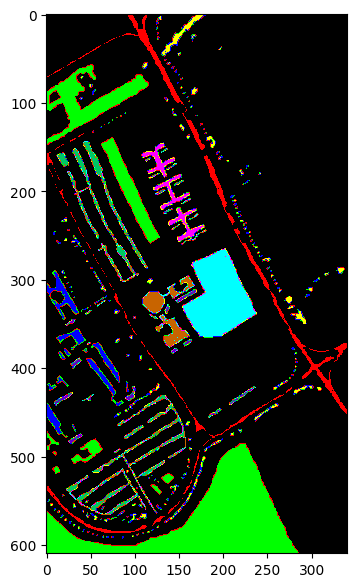

In [40]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

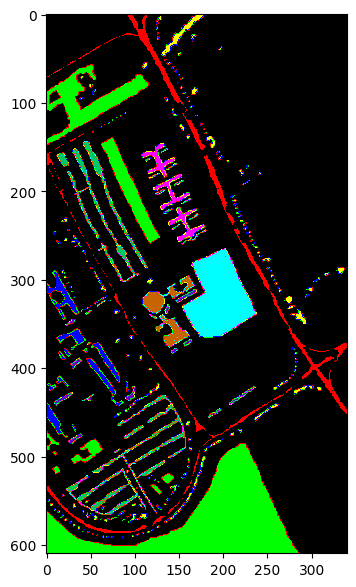

In [48]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [42]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

# Pure Pixels

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)